# Hierarchical Clustering

This data set contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

A data frame with 50 observations on 4 variables.

- Murder numeric Murder arrests (per 100,000)
- Assault numeric Assault arrests (per 100,000)
- UrbanPop numeric Percent urban population (%)
- Rape numeric Rape arrests (per 100,000)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/kadiryildirim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("USArrests.csv", index_col=0)

In [3]:
df.head()

# ülkeleri, şehirleri, eyaletleri suçlarına göre,
# öğrencileri başarılarına göre,
# müşterileri harcama sıklık ve miktarlarına göre,
# insanları fiziksel özelliklerien göre segmente etmek için domain bilgisi olmadan da bu işlemleri yapabiliriz.

Murder  Assault  UrbanPop  Rape
Alabama       13.2      236        58  21.2
Alaska        10.0      263        48  44.5
Arizona        8.1      294        80  31.0
Arkansas       8.8      190        50  19.5
California     9.0      276        91  40.6

## Exploratory Data Analysis and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [5]:
df.describe().T

count     mean        std   min      25%     50%      75%    max
Murder     50.0    7.788   4.355510   0.8    4.075    7.25   11.250   17.4
Assault    50.0  170.760  83.337661  45.0  109.000  159.00  249.000  337.0
UrbanPop   50.0   65.540  14.474763  32.0   54.500   66.00   77.750   91.0
Rape       50.0   21.232   9.366385   7.3   15.075   20.10   26.175   46.0

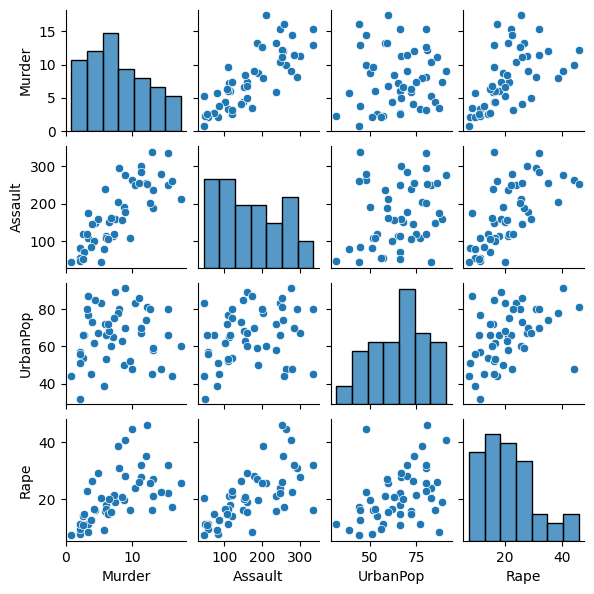

In [6]:
sns.pairplot(df, size=1.5);

# Kaç cluster olabileceğine dair net bir insight elde edemiyoruz ancak bazı görsellerde 2 cluster olabileceğini
# değerlendiriyoruz.

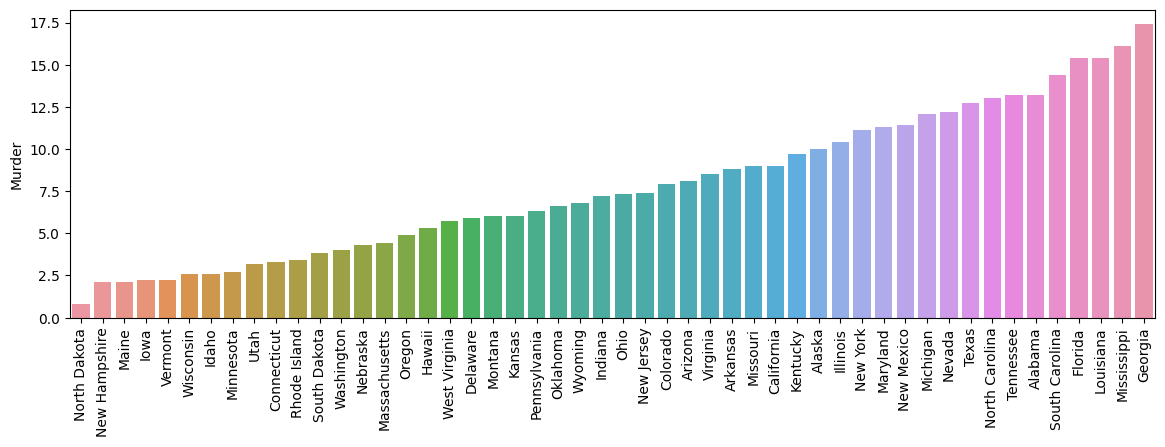

In [7]:
murder = df.Murder.sort_values()

plt.figure(figsize=(14,4))
sns.barplot(x=murder.index, 
            y=murder)
plt.xticks(rotation=90);

# cinayet suçuna göre sıralıyoruz.

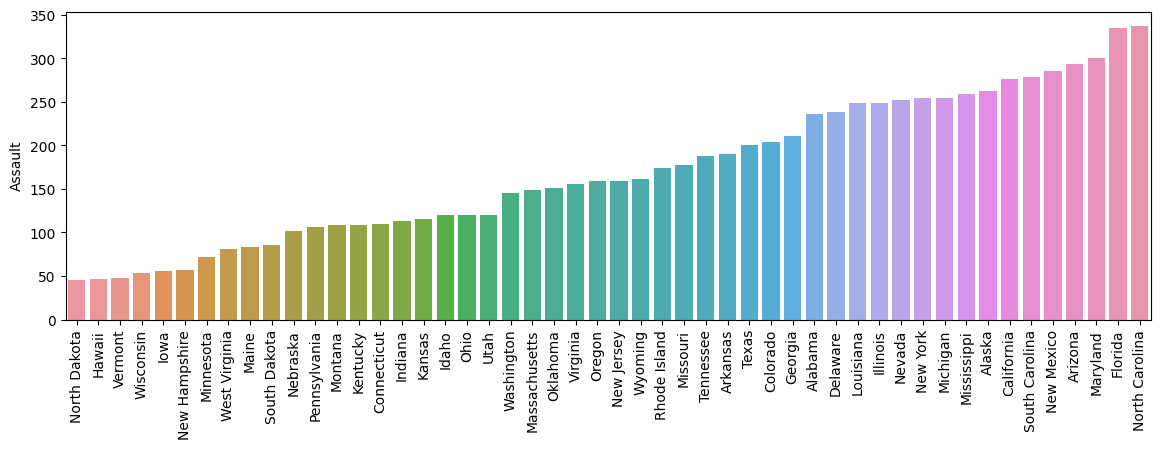

In [8]:
assault = df.Assault.sort_values()

plt.figure(figsize=(14,4))
sns.barplot(x=assault.index,
            y=assault)
plt.xticks(rotation=90);

# fiziki saldırı suçuna göre sıralıyoruz.

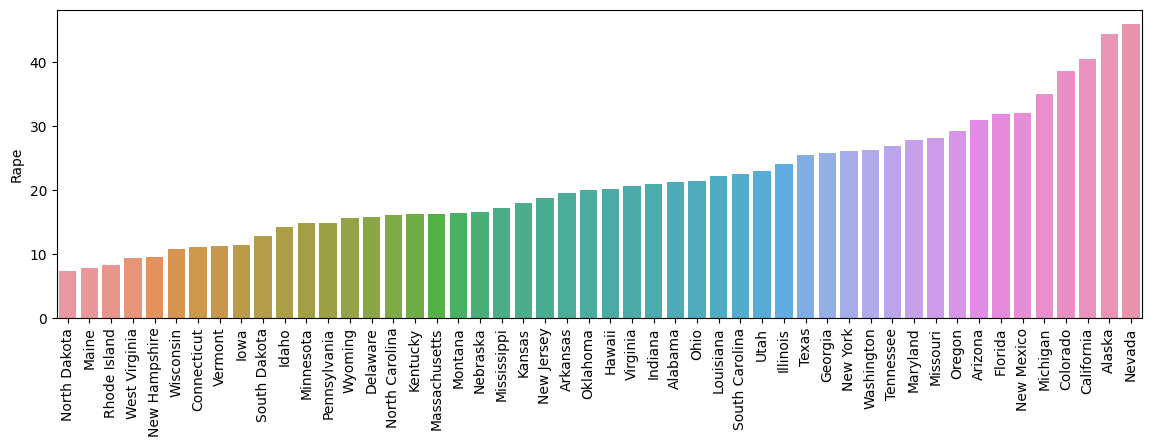

In [9]:
rape = df.Rape.sort_values()

plt.figure(figsize=(14,4))
sns.barplot(x=rape.index,
            y=rape)
plt.xticks(rotation=90);

# tecavüz/taciz suçuna göre sıralıyoruz.

## Hopkins Test

- Hopkins test, a statistical test for randomness of a variable.
- Null Hypothesis (Ho) : Data points are generated by non-random, uniform distribution (implying no meaningful clusters)
- Alternate Hypothesis (Ha): Data points are generated by random data points (presence of clusters)
- The more close 0, the more available to separate clusters

In [10]:
#!pip install pyclustertend
#from pyclustertend import hopkins

In [11]:
from sklearn.neighbors import BallTree

def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.

    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.

    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)

    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """

    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    # Sample n observations from D : P

    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')

    data_frame_sample = data_frame.sample(n=sampling_size)

    # Get the distance to their neirest neighbors in D : X

    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]

    # Randomly simulate n points with the same variation as in D : Q.

    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()

    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)

    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)

    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)

    # Get the distance to their neirest neighbors in D : Y

    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist

    # return the hopkins score

    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')

    return x / (x + y)[0]

In [12]:
hopkins(df, df.shape[0])  # without scaling

0.444846039796566

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [14]:
df1 = df.copy()
df2 = df.copy()

In [15]:
hopkins(MinMaxScaler().fit_transform(df1), df1.shape[0])

0.3821071737980291

In [16]:
hopkins(StandardScaler().fit_transform(df2), df2.shape[0])

0.393888806445181

In [17]:
scaler = MinMaxScaler()

# minmaxscaler ve satandartscaler göre iki ayrı şekilde datayı scalledim ama hopkins testleri yaklaışk çıktı.
# minmax ile devam ediyoruz. siz standartscale ile de devam edebilirsiniz.

In [18]:
df_scaled = scaler.fit_transform(df)

In [19]:
X = pd.DataFrame(df_scaled, columns=df.columns)
X.head()

Murder   Assault  UrbanPop      Rape
0  0.746988  0.654110  0.440678  0.359173
1  0.554217  0.746575  0.271186  0.961240
2  0.439759  0.852740  0.813559  0.612403
3  0.481928  0.496575  0.305085  0.315245
4  0.493976  0.791096  1.000000  0.860465

## Dendrogram

- Tree-like hierarchical representation of clusters is called a dendrogram.   
- It illustrates the arrangement of the clusters produced by the corresponding analyses.

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [21]:
#dendrogram()

**“linkage” parameter: (default= “ward”)**

  {‘ward’, ‘complete’, ‘average’, ‘single’}

Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. 
-	Ward minimizes the variance of the clusters being merged.
-	Average uses the average of the distances of each observation of the two sets.
-	Complete or maximum linkage uses the maximum distances between all observations of the two sets.
-	Single uses the minimum of the distances between all observations of the two sets.


In [22]:
hc_ward = linkage(y = X, method = "ward")
hc_complete = linkage(X, "complete")
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

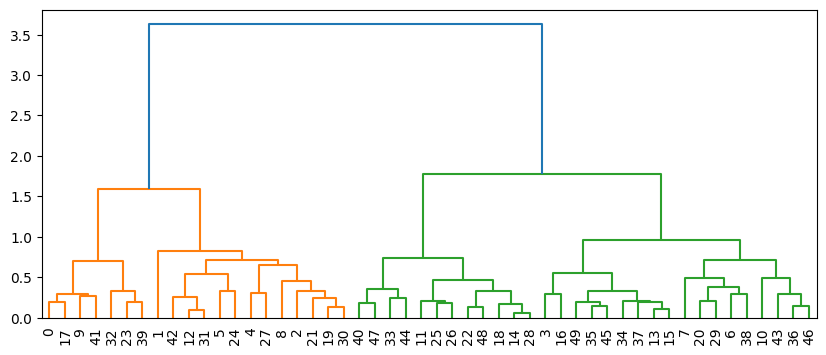

In [23]:
plt.figure(figsize = (10,4))
dendrogram(hc_ward, leaf_font_size = 10);
# 2 küme icin mesafe 1.9 birim gibi (3.6-1.7); 3 küme de ise turuncu 1.55ten basliyor, aradaki mesafe cok dusuk, sadece 
# 0.2 gibi. 2 kümede kümeler birbirinden daha uzak. 
# 4 küme de optimal adayi, distance 0.6,  bu nedenle hepsini deneyecegiz

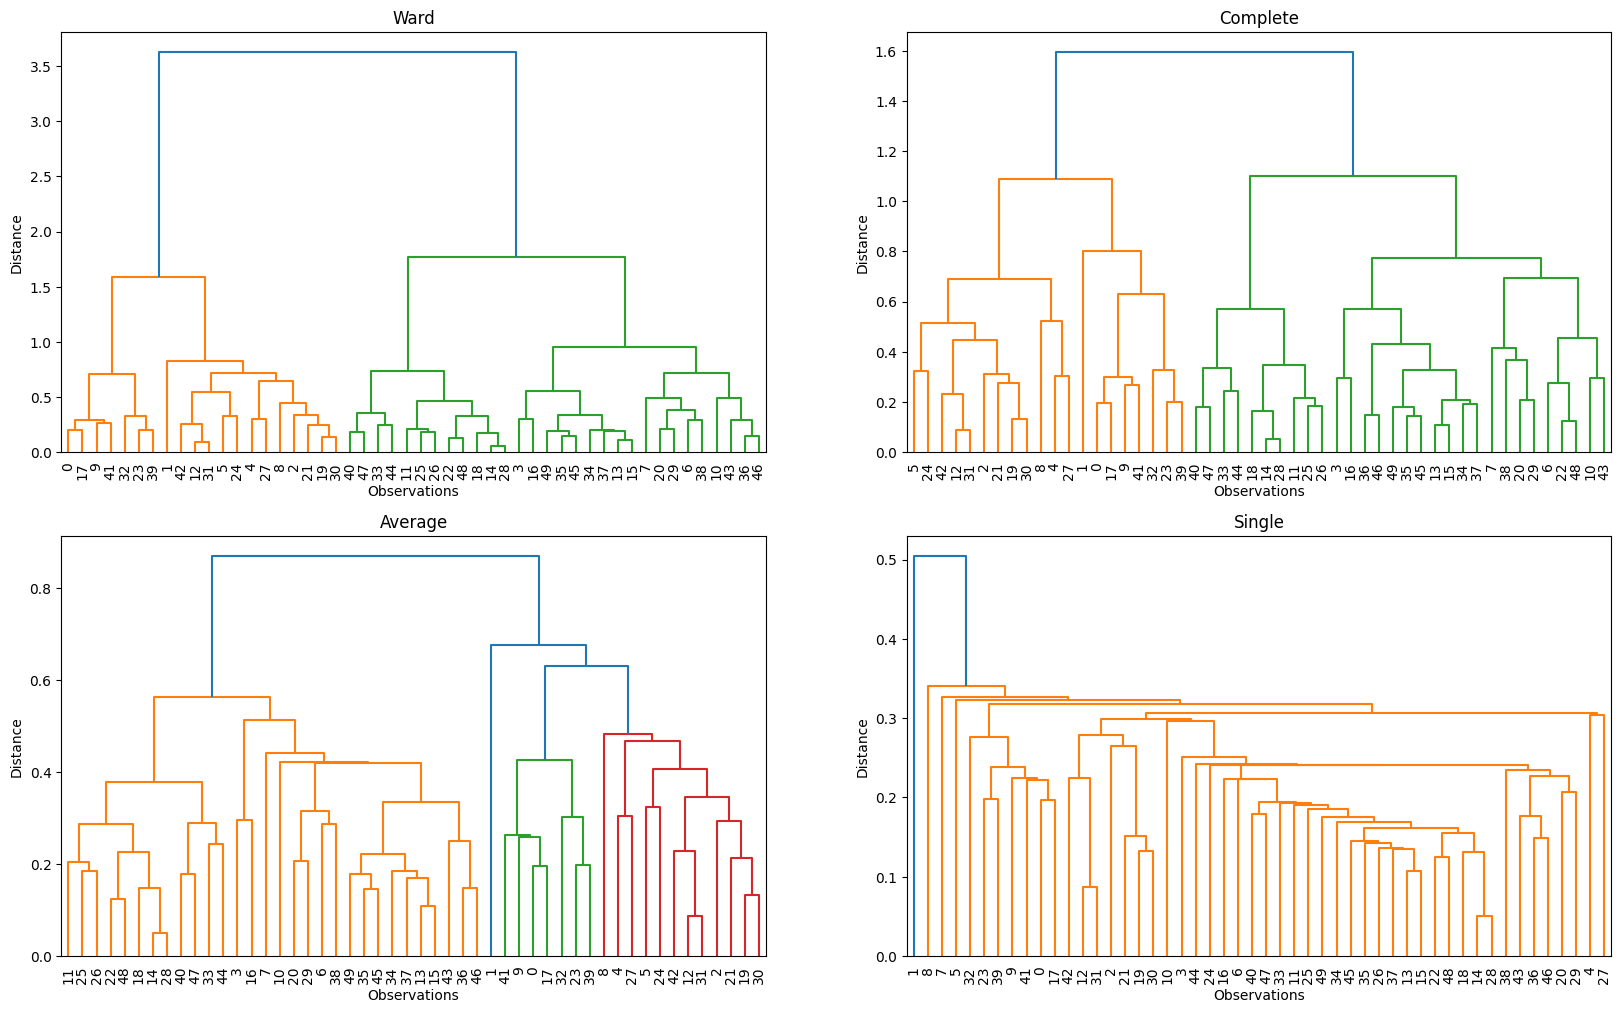

In [24]:
plt.figure(figsize=(20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size=10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size=10);
# en iyi değer ward ile (rangelere dikkat)

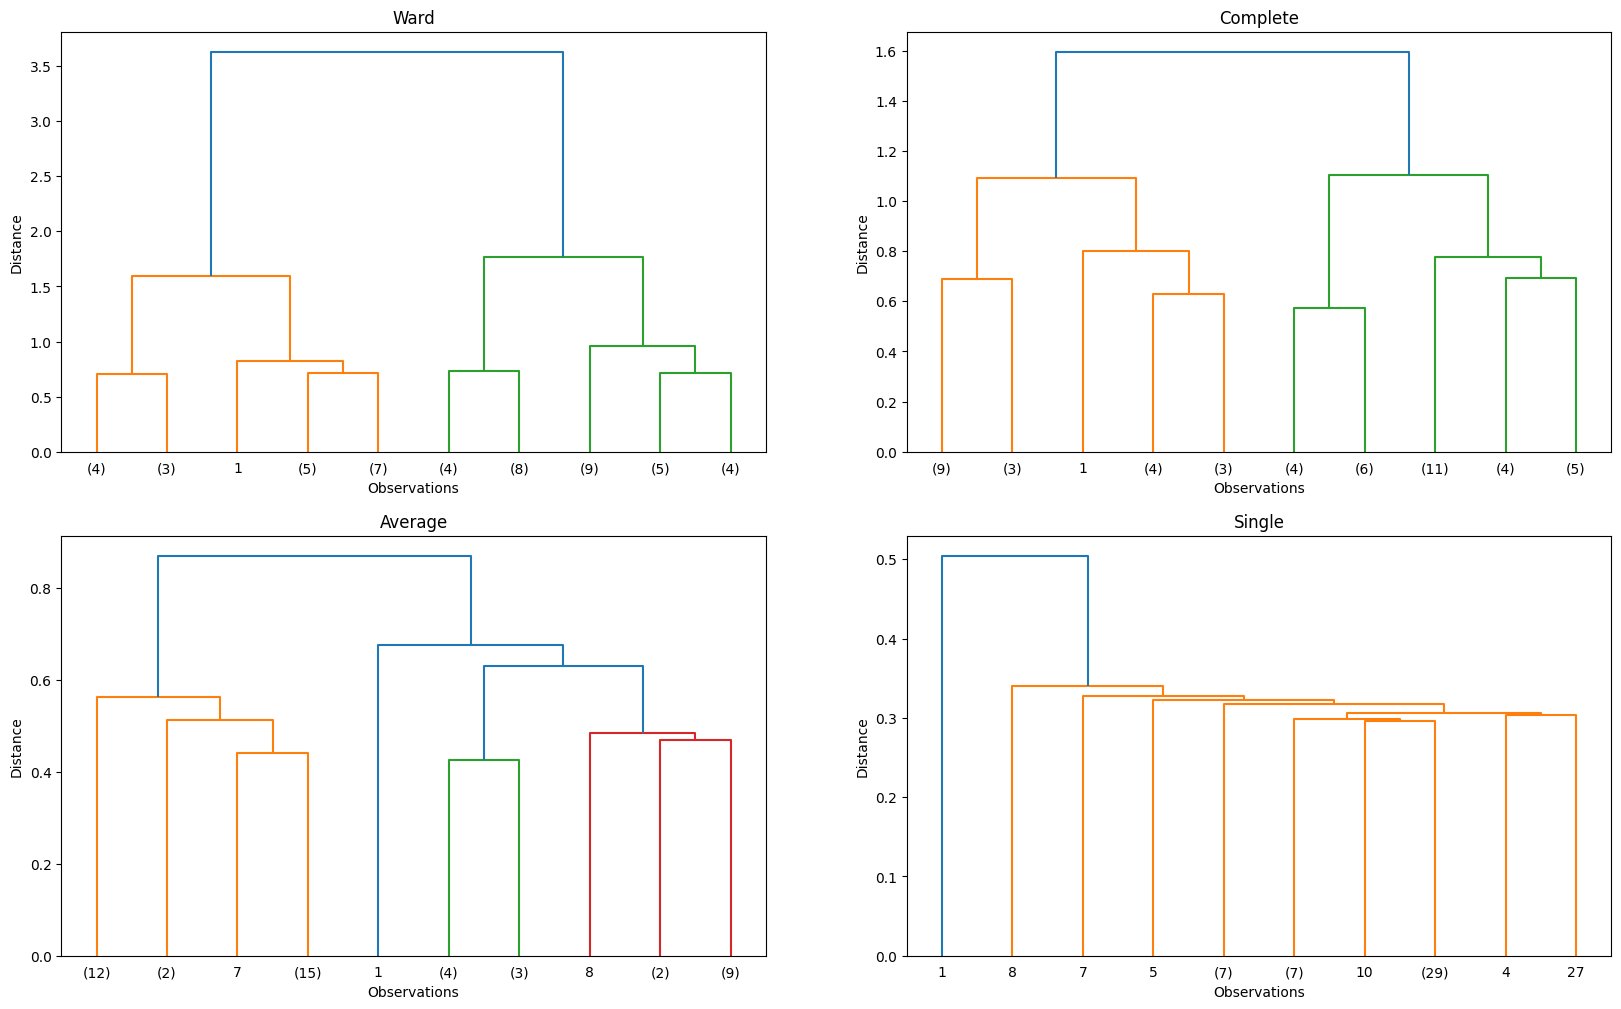

In [25]:
plt.figure(figsize=(20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size=10, truncate_mode='lastp', p=10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size=10, truncate_mode='lastp', p=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size=10, truncate_mode='lastp', p=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size=10, truncate_mode='lastp', p=10);

## Hierarchical Clustering (Agglomerative)

- Ideal clustering is characterised by minimal intra cluster distance and maximal inter cluster distanc

In [26]:
from sklearn.cluster import AgglomerativeClustering

### S(Silhouette) Score

- If the ground truth labels are not known, evaluation must be performed using the model itself. (One of the evaluation method is Silhouette Coefficient)
- A higher Silhouette Coefficient score relates to a model with better defined clusters. 
- a :The mean distance between a sample and all other points in the same class.
  b: The mean distance between a sample and all other points in the next nearest cluster.

s = (b-a) / max(a,b)

In [27]:
from sklearn.metrics import silhouette_score

In [28]:
K = range(2,10)

for k in K:
    model = AgglomerativeClustering(n_clusters=k)
    model.fit_predict(X)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(X, model.labels_)}')

Silhouette Score for 2 clusters: 0.42364457559625074
Silhouette Score for 3 clusters: 0.31916915428121284
Silhouette Score for 4 clusters: 0.3298707379986785
Silhouette Score for 5 clusters: 0.28290124293256447
Silhouette Score for 6 clusters: 0.28134198599501803
Silhouette Score for 7 clusters: 0.26010746919769046
Silhouette Score for 8 clusters: 0.23007745711627264
Silhouette Score for 9 clusters: 0.24179562627700718


In [29]:
# 3 ile deneyerek baslayalim
model = AgglomerativeClustering(n_clusters=3,
                                affinity="euclidean",
                                linkage="ward")
clusters = model.fit_predict(X)

# 3 clustera göre scatter plot üzerinden iyi bir ayrım yapıp yapamadığımızı gözlemleyeceğiz.

In [30]:
X.head()

Murder   Assault  UrbanPop      Rape
0  0.746988  0.654110  0.440678  0.359173
1  0.554217  0.746575  0.271186  0.961240
2  0.439759  0.852740  0.813559  0.612403
3  0.481928  0.496575  0.305085  0.315245
4  0.493976  0.791096  1.000000  0.860465

In [31]:
X["clusters"] = clusters
X.head()

Murder   Assault  UrbanPop      Rape  clusters
0  0.746988  0.654110  0.440678  0.359173         0
1  0.554217  0.746575  0.271186  0.961240         0
2  0.439759  0.852740  0.813559  0.612403         0
3  0.481928  0.496575  0.305085  0.315245         1
4  0.493976  0.791096  1.000000  0.860465         0

<Figure size 2000x1000 with 0 Axes>

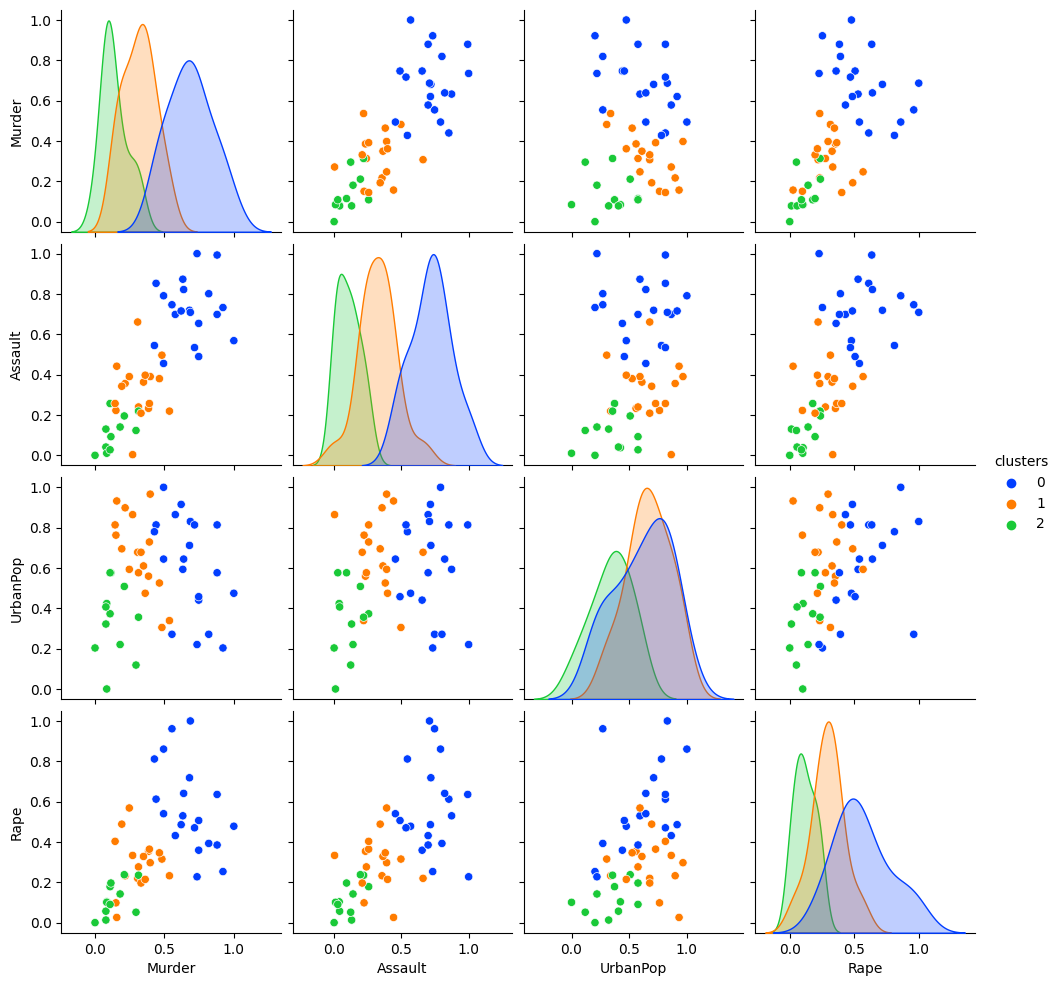

In [32]:
plt.figure(figsize=(20,10))
sns.pairplot(X, hue="clusters", palette="bright");

# 3 clustera göre kümelenin az suç işlenen, ortalama suç işlenen , çok suç işlenen eyaletler olarak iyi bir ayrım yapamadığını
# görüyoruz. Bu sebeple 2 cluster yapıp göresellerimizi az suç işlenen çok suç işlenen eyaletler şeklinde tekrar inceleyeceğiz

In [33]:
# 2 clusters
model = AgglomerativeClustering(n_clusters=2,
                                affinity="euclidean",
                                linkage="ward")
clusters = model.fit_predict(X)

In [34]:
X["clusters"] = clusters
X.head()

Murder   Assault  UrbanPop      Rape  clusters
0  0.746988  0.654110  0.440678  0.359173         1
1  0.554217  0.746575  0.271186  0.961240         1
2  0.439759  0.852740  0.813559  0.612403         1
3  0.481928  0.496575  0.305085  0.315245         0
4  0.493976  0.791096  1.000000  0.860465         1

<Figure size 2000x1000 with 0 Axes>

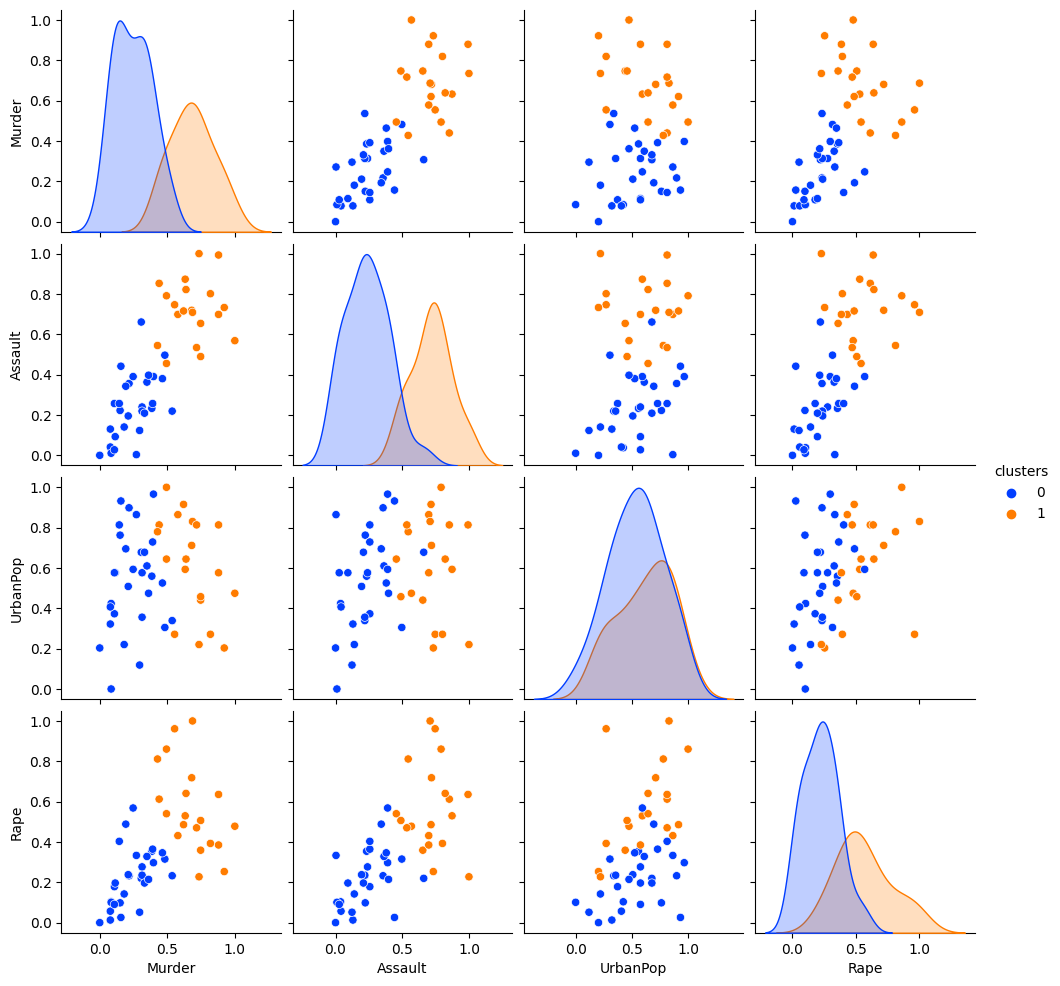

In [35]:
plt.figure(figsize = (20,10))
sns.pairplot(data=X, hue="clusters", palette="bright");

# 2 clustera göre az suç işlenen çok suç işlenen eyaletler şeklinde tekrar inceledeğimizde daha iyi bir ayrım olduğunu 
# görüyoruz. Bu sebeple 2 cluster ile devam edeceğiz.

In [36]:
import plotly.express as px

fig = px.scatter_3d(X, 
                    x='Murder',
                    y='Assault',
                    z='Rape',
                    color='clusters')
fig.show();

In [37]:
clus_pred = X.groupby("clusters").mean().T
clus_pred
# her clastır için her featuran ortalama değerlerini alıp bu değerler üzerinden featurların biribirylr girift olup olmadığını
# tespit etmeye çalışacağız.

clusters         0         1
Murder    0.245181  0.684639
Assault   0.237785  0.720034
UrbanPop  0.536158  0.616949
Rape      0.223342  0.564987

<Axes: >

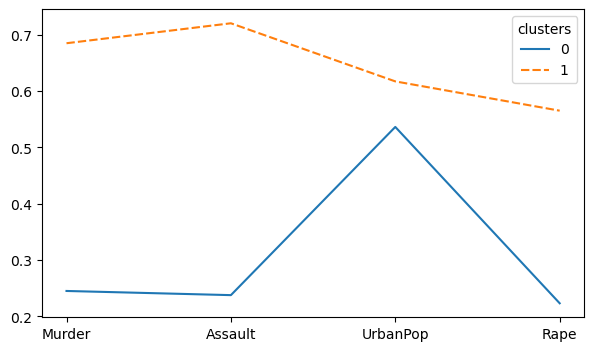

In [38]:
sns.lineplot(data=clus_pred)

## en iyi ayrışımın olduğu ve hangi featurelarda datam giriftleşiyor onu görmek için çiziyoruz bu lineplot'u.

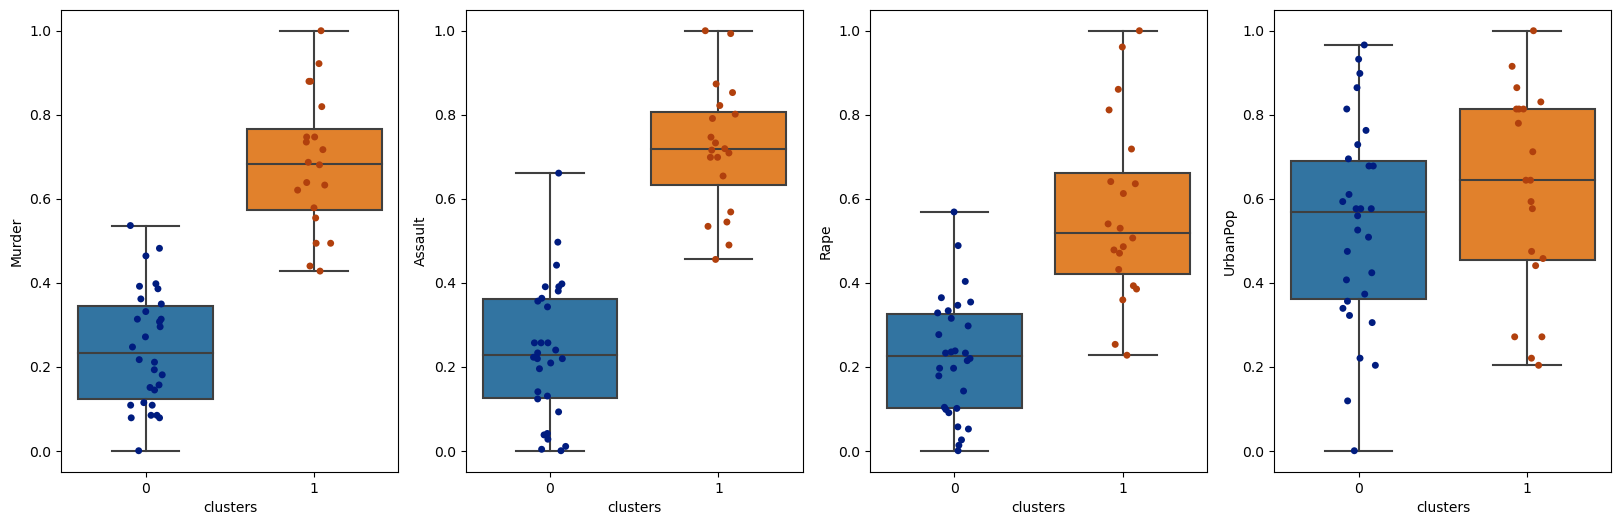

In [39]:
plt.figure(figsize = (20,6))

plt.subplot(141)
sns.boxplot(y="Murder", x="clusters", data=X)
sns.stripplot(y="Murder", x="clusters", data=X, palette="dark")

plt.subplot(142)
sns.boxplot(y="Assault", x="clusters", data=X)
sns.stripplot(y="Assault", x="clusters", data=X, palette="dark")

plt.subplot(143)
sns.boxplot(y="Rape", x="clusters", data=X)
sns.stripplot(y="Rape", x="clusters", data=X, palette="dark")

plt.subplot(144)
sns.boxplot(y="UrbanPop", x="clusters", data=X)
sns.stripplot(y="UrbanPop", x="clusters", data=X, palette="dark");

# clusterların birbiriylr grift olup olmadıklarını daha net görebilmek için ayrıca boxplot ve strip plot üzerinden
# clusterları her feature özelindeki dağolımı kontrol ediyoruz.

# urbanpopun en grift olan featura olduğunu tespit ettiğimizden bu feature drop edeceğiz.

In [40]:
X.clusters.value_counts()

# 0 ve 1 classlarının bana neyi tarif ettiğini iyi tespit etmem gerekiyor

0    30
1    20
Name: clusters, dtype: int64

In [41]:
X2 = X.iloc[:, [0, 1, 3]]
X2.head()

# urbanpop'u drop ignore edip datayı yeniden oluşturuyoruz.

Murder   Assault      Rape
0  0.746988  0.654110  0.359173
1  0.554217  0.746575  0.961240
2  0.439759  0.852740  0.612403
3  0.481928  0.496575  0.315245
4  0.493976  0.791096  0.860465

## Hopkins test

In [42]:
hopkins(X2, X2.shape[0]) # hopkins test en az 2 feature ister. 0.366 --> 0.329

0.3292601333974313

In [43]:
hc_ward = linkage(y=X2, method="ward")
hc_complete = linkage(X2, "complete")
hc_average = linkage(X2, "average")
hc_single = linkage(X2, "single")

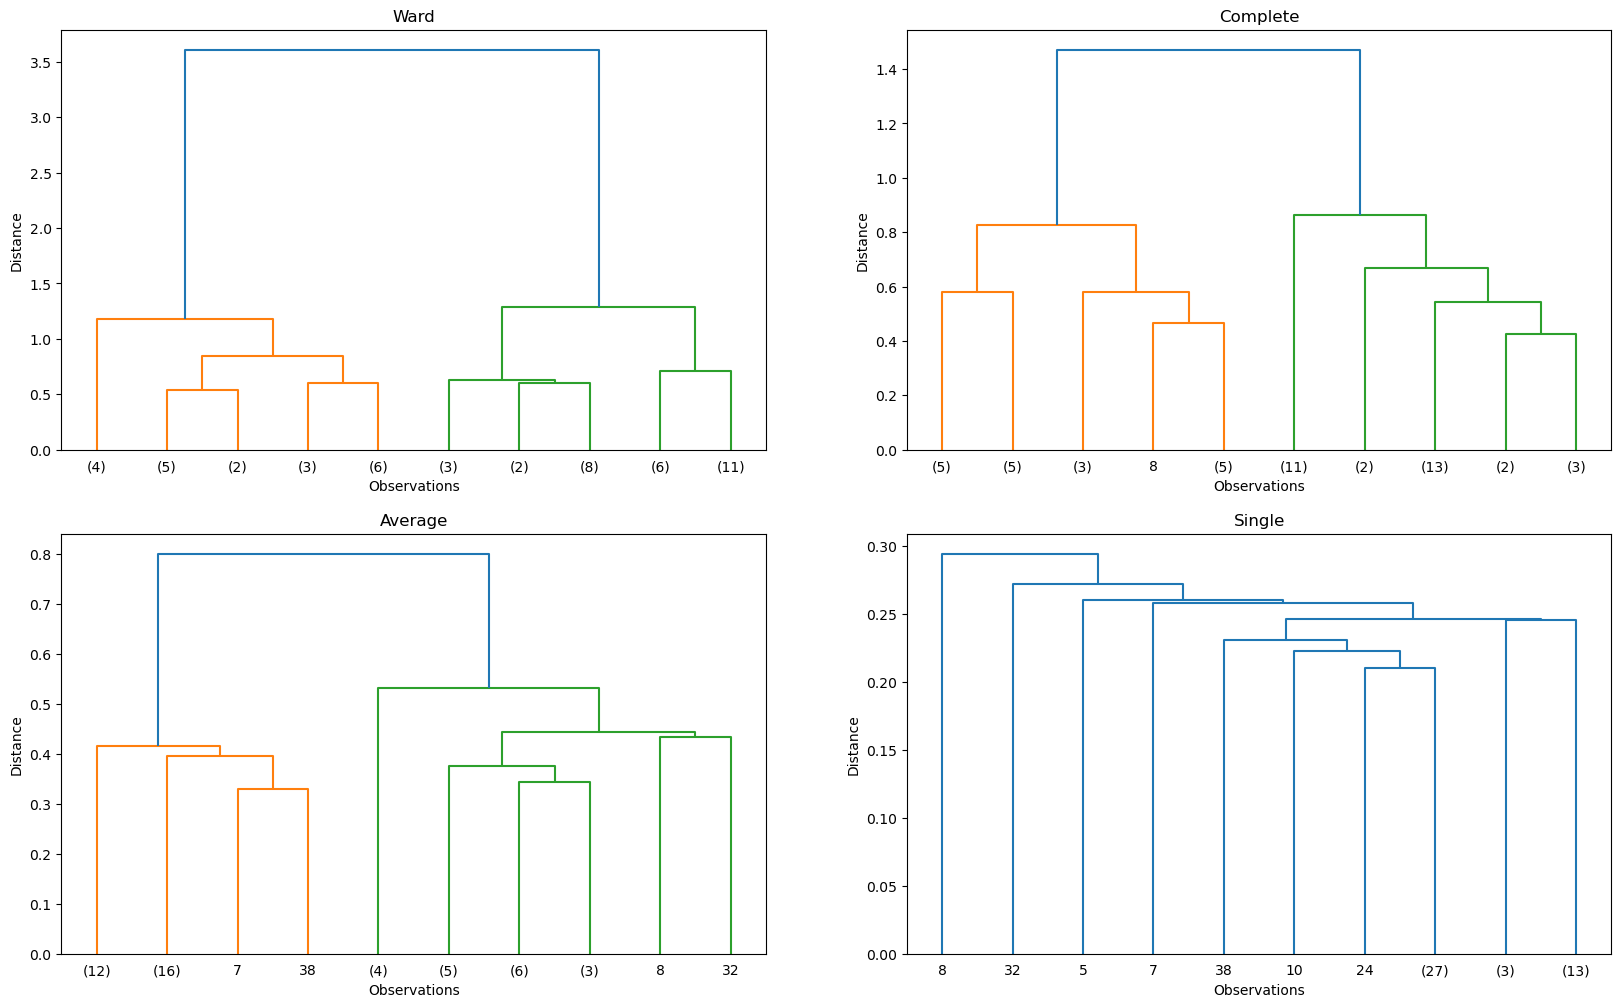

In [44]:
plt.figure(figsize=(20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode="lastp", p=10, leaf_font_size=10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, truncate_mode="lastp", p=10, leaf_font_size=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, truncate_mode="lastp", p=10, leaf_font_size=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, truncate_mode="lastp", p=10, leaf_font_size=10);

In [45]:
K = range(2,11)

for k in K:
    model = AgglomerativeClustering(n_clusters=k)
    model.fit_predict(X2)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(X2, model.labels_)}')

Silhouette Score for 2 clusters: 0.5292236374572644
Silhouette Score for 3 clusters: 0.34107037436424575
Silhouette Score for 4 clusters: 0.33426007774452093
Silhouette Score for 5 clusters: 0.3007534571726004
Silhouette Score for 6 clusters: 0.25513926498262485
Silhouette Score for 7 clusters: 0.28780018015625386
Silhouette Score for 8 clusters: 0.30204265966542065
Silhouette Score for 9 clusters: 0.3097011452588472
Silhouette Score for 10 clusters: 0.3175989746439034


In [46]:
final_model = AgglomerativeClustering(n_clusters=2,
                                      affinity="euclidean",
                                      linkage="ward")
clusters = final_model.fit_predict(X2)
X2["clusters"] = clusters
X2.head()

Murder   Assault      Rape  clusters
0  0.746988  0.654110  0.359173         1
1  0.554217  0.746575  0.961240         1
2  0.439759  0.852740  0.612403         1
3  0.481928  0.496575  0.315245         0
4  0.493976  0.791096  0.860465         1

In [47]:
X2.clusters.value_counts()

0    30
1    20
Name: clusters, dtype: int64

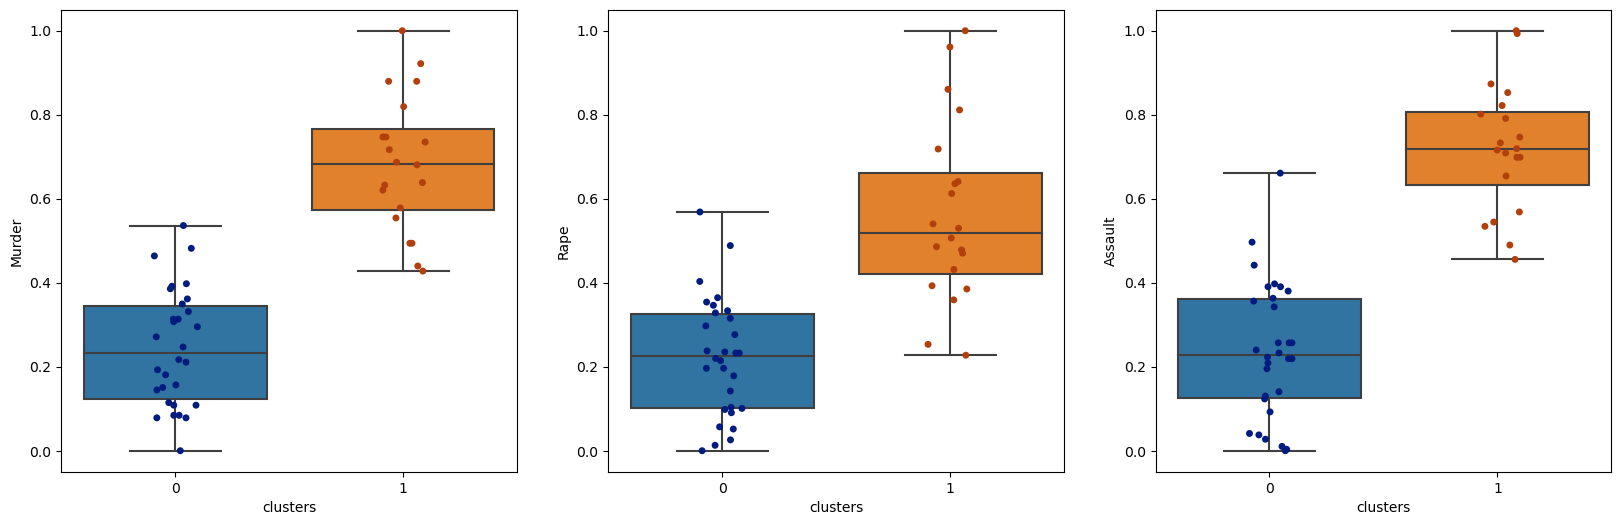

In [48]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.boxplot(y="Murder", x="clusters", data=X2)
sns.stripplot(y="Murder", x="clusters", data=X2, palette="dark")

plt.subplot(132)
sns.boxplot(y="Rape", x="clusters", data=X2)
sns.stripplot(y="Rape", x="clusters", data=X2, palette="dark")

plt.subplot(133)
sns.boxplot(y="Assault", x="clusters", data=X2)
sns.stripplot(y="Assault", x="clusters", data=X2, palette="dark");
# rape de örtüsme daha fazla, belki onsuz da kurulabilir model. murder icin sadece 3 nokta gibi, assaultta 2-3


<Figure size 2000x1000 with 0 Axes>

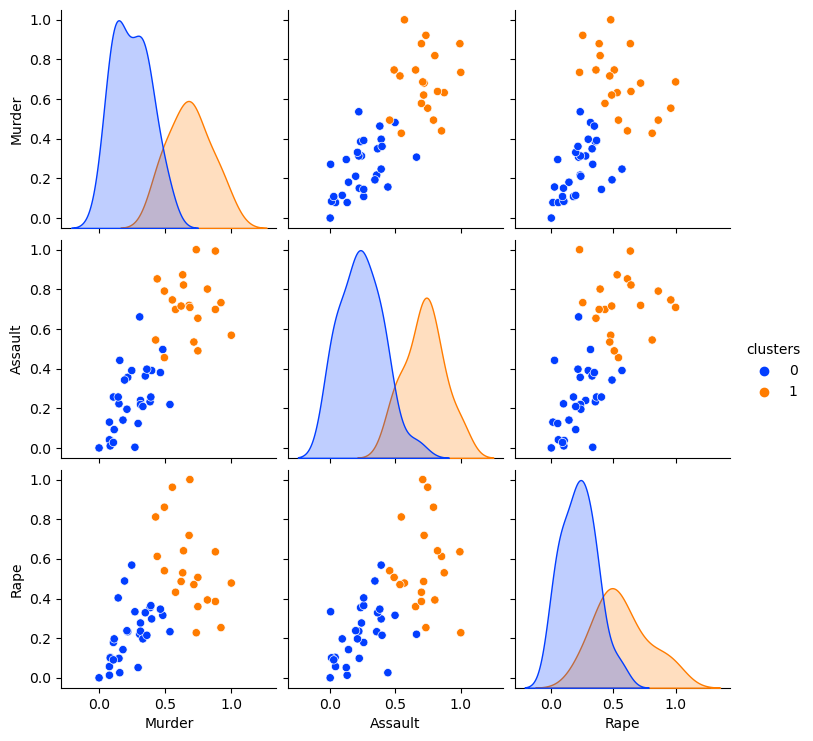

In [49]:
plt.figure(figsize=(20,10))
sns.pairplot(data=X2, hue="clusters", palette="bright");

**Evaluation**

- 0 : states with low crime rates
- 1 : states with high crime rates

In [50]:
X2["crime_level"] = X2["clusters"].map({0: "low", 1: "high"})
X2.head()

Murder   Assault      Rape  clusters crime_level
0  0.746988  0.654110  0.359173         1        high
1  0.554217  0.746575  0.961240         1        high
2  0.439759  0.852740  0.612403         1        high
3  0.481928  0.496575  0.315245         0         low
4  0.493976  0.791096  0.860465         1        high

In [51]:
df.index

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

In [52]:
X2["States"] = df.index
X2.sample(10)

Murder   Assault      Rape  clusters crime_level        States
23  0.921687  0.732877  0.253230         1        high   Mississippi
4   0.493976  0.791096  0.860465         1        high    California
17  0.879518  0.698630  0.385013         1        high     Louisiana
30  0.638554  0.821918  0.640827         1        high    New Mexico
38  0.156627  0.441781  0.025840         0         low  Rhode Island
24  0.493976  0.455479  0.540052         1        high      Missouri
29  0.397590  0.390411  0.297158         0         low    New Jersey
11  0.108434  0.256849  0.178295         0         low         Idaho
44  0.084337  0.010274  0.100775         0         low       Vermont
36  0.246988  0.390411  0.568475         0         low        Oregon

In [53]:
X2[X2.crime_level=="low"]["States"]

3          Arkansas
6       Connecticut
7          Delaware
10           Hawaii
11            Idaho
13          Indiana
14             Iowa
15           Kansas
16         Kentucky
18            Maine
20    Massachusetts
22        Minnesota
25          Montana
26         Nebraska
28    New Hampshire
29       New Jersey
33     North Dakota
34             Ohio
35         Oklahoma
36           Oregon
37     Pennsylvania
38     Rhode Island
40     South Dakota
43             Utah
44          Vermont
45         Virginia
46       Washington
47    West Virginia
48        Wisconsin
49          Wyoming
Name: States, dtype: object

In [54]:
X2[X2.crime_level=="high"]["States"]

0            Alabama
1             Alaska
2            Arizona
4         California
5           Colorado
8            Florida
9            Georgia
12          Illinois
17         Louisiana
19          Maryland
21          Michigan
23       Mississippi
24          Missouri
27            Nevada
30        New Mexico
31          New York
32    North Carolina
39    South Carolina
41         Tennessee
42             Texas
Name: States, dtype: object